In [2]:
import time
import warnings
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

from sklearn import cluster
from sklearn import datasets as ds
from sklearn.neighbors import kneighbors_graph
from sklearn.preprocessing import StandardScaler

In [3]:
## 设置属性防止中文乱码
mpl.rcParams['font.sans-serif'] = [u'SimHei']
mpl.rcParams['axes.unicode_minus'] = False
warnings.filterwarnings(action='ignore', category=UserWarning)

In [4]:
## 产生模拟数据
n_samples = 1500
np.random.seed(0)
#产生圆形的
noisy_circles = ds.make_circles(n_samples=n_samples, factor=.5, noise=.05)
#产生月牙形
noisy_moons = ds.make_moons(n_samples=n_samples, noise=.05)
#高斯分布
blobs = ds.make_blobs(n_samples=n_samples, n_features=2, cluster_std=0.5, centers=3, random_state=0)
no_structure = (np.random.rand(n_samples, 2), np.ones(n_samples))

datasets = [noisy_circles, noisy_moons, blobs, no_structure]
clusters = [2,2,3,2]

In [5]:
no_structure

(array([[0.59945663, 0.24694133],
        [0.5173267 , 0.57255303],
        [0.55229185, 0.40567924],
        ...,
        [0.8384347 , 0.52906874],
        [0.84228843, 0.11517496],
        [0.91963613, 0.22592146]]), array([1., 1., 1., ..., 1., 1., 1.]))

In [6]:
noisy_moons

(array([[ 0.49627131, -0.34275349],
        [-0.16629956,  0.92234209],
        [ 0.71895601,  0.66529038],
        ...,
        [ 1.90950927,  0.02989686],
        [ 0.54623069, -0.36003133],
        [ 0.04090016,  0.37069297]]),
 array([1, 0, 0, ..., 1, 1, 1], dtype=int64))

In [7]:
def expandBorder(a, b):
    """边界扩充"""
    d = (b - a) * 0.1
    return a-d, b+d

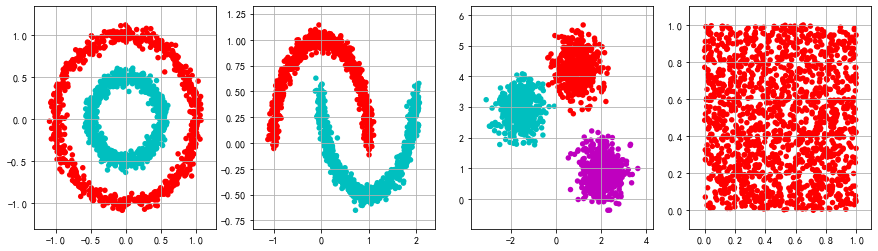

In [8]:
## 五、画图
cm = mpl.colors.ListedColormap(list('rgbmyc'))
plt.figure(figsize=(15, 9), facecolor='w')

for i in range(4):
    # data原始数据绘制
    plt.subplot(241 + i)
    plt.scatter(datasets[i][0][:, 0], datasets[i][0][:, 1], c=datasets[i][1], s=30, cmap=cm, edgecolors='none')
    x1_min, x2_min = np.min(datasets[i][0], axis=0)
    x1_max, x2_max = np.max(datasets[i][0], axis=0)
    x1_min, x1_max = expandBorder(x1_min, x1_max)
    x2_min, x2_max = expandBorder(x2_min, x2_max)
    plt.xlim((x1_min, x1_max))
    plt.ylim((x2_min, x2_max))
    plt.grid(True)
plt.show()

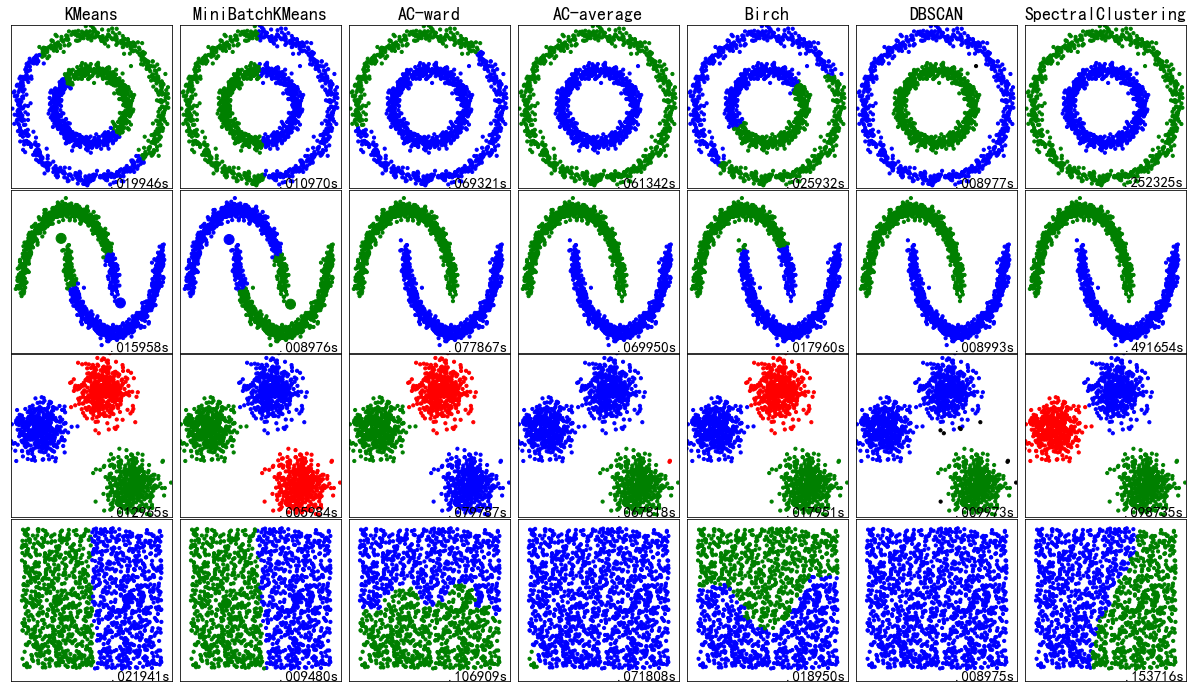

In [9]:
clustering_names = [
    'KMeans', 'MiniBatchKMeans', 'AC-ward', 'AC-average',
    'Birch', 'DBSCAN', 'SpectralClustering']

## 开始画图
plt.figure(figsize=(len(clustering_names) * 2 + 3, 9.5), facecolor='w')
plt.subplots_adjust(left=.02, right=.98, bottom=.001, top=.96, wspace=.05,hspace=.01)
colors = np.array([x for x in 'bgrcmykbgrcmykbgrcmykbgrcmyk'])
colors = np.hstack([colors] * 20)
plot_num = 1
for i_dataset, (dataset, n_cluster) in enumerate(zip(datasets, clusters)):
    
    X, y = dataset
    
    # 将数据线进行标准化
    X = StandardScaler().fit_transform(X)
    connectivity = kneighbors_graph(X, n_neighbors=10, include_self=False)
    connectivity = 0.5 * (connectivity + connectivity.T)
    
    # K-Means算法
    km = cluster.KMeans(n_clusters=n_cluster)
    # Mini-batch K-Menas算法
    mbkm = cluster.MiniBatchKMeans(n_clusters=n_cluster)
    # 层次聚类
    ward = cluster.AgglomerativeClustering(n_clusters=n_cluster,connectivity=connectivity, linkage='ward')
    average = cluster.AgglomerativeClustering(n_clusters=n_cluster,connectivity=connectivity, linkage='average')
    # Brich平衡迭代消减聚类法
    birch = cluster.Birch(n_clusters=n_cluster)
    # 密度聚类
    dbscan = cluster.DBSCAN(eps=.2)
    # 谱聚类
    spectral = cluster.SpectralClustering(n_clusters=n_cluster, eigen_solver='arpack', affinity="nearest_neighbors")
    
    # 聚类算法列表
    clustering_algorithms = [km, mbkm, ward, average, birch, dbscan, spectral]
    
    for name, algorithm in zip(clustering_names, clustering_algorithms):
        t0 = time.time()
        algorithm.fit(X)
        t1 = time.time()
        # 如果模型中存在"labels__"这个属性的话，那么获取这个预测的类别值
        if hasattr(algorithm, 'labels_'):
            y_pred = algorithm.labels_.astype(np.int)
        else:
            y_pred = algorithm.predict(X)

        # 画子图
        plt.subplot(4, len(clustering_algorithms), plot_num)
        if i_dataset == 0:
            plt.title(name, size=18)
        plt.scatter(X[:, 0], X[:, 1], color=colors[y_pred].tolist(), s=10)
        # 如果模型有中心点属性，那么画出中心点
        if hasattr(algorithm, 'cluster_centers_'):
            centers = algorithm.cluster_centers_
            center_colors = colors[:len(centers)]
            plt.scatter(centers[:, 0], centers[:, 1], s=100, c=center_colors)
        plt.xlim(-2, 2)
        plt.ylim(-2, 2)
        plt.xticks(())
        plt.yticks(())
        plt.text(.99, .01, ('%2fs' % (t1 - t0)).lstrip('0'),
                 transform=plt.gca().transAxes, size=15,
                 horizontalalignment='right')
        plot_num += 1

plt.show()